In [1]:
# ! pip install librosa
# ! pip install parselmouth
# ! pip install pyAudioAnalysis
# ! pip install torch
# ! pip install transformers
# ! pip install pandas
# ! pip install tqdm
# ! pip install scikit-learn
# ! pip install parselmouth
# ! pip install nolds

In [2]:
%cd Project

/content/Project


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchaudio
import librosa
import parselmouth
from parselmouth.praat import call
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, WhisperModel, AutoModelForAudioClassification
import logging
import gc
from torch.utils.data import Dataset, DataLoader
import nolds

2025-04-10 19:27:26.486132: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 19:27:26.487659: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 19:27:26.516022: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 19:27:26.517045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 19:27:27.718774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [4]:
base_path = "ParkCeleb_filtered"
groups = {"PD": 1, "CN": 0}

parkinson_files = []
control_files = []

# Loop over each group (PD, CN)
for group, label in groups.items():
    group_path = os.path.join(base_path, group)
    # Recursively search for any .wav file
    wav_files = glob(os.path.join(group_path, "**", "*.wav"), recursive=True)

    if label == 1:
        parkinson_files.extend(wav_files)
    else:
        control_files.extend(wav_files)

# Merge and create labels
all_files = parkinson_files + control_files
labels = [1] * len(parkinson_files) + [0] * len(control_files)

print(f"Found {len(parkinson_files)} Parkinson files and {len(control_files)} Control files.")


Found 8708 Parkinson files and 5349 Control files.


# Load ParkCeleb dataset and extract speaker IDs

In [5]:
def load_parkceleb_dataset_with_speakers(dataset_path):
    groups = {"PD": 1, "CN": 0}
    audio_files = []
    labels = []
    speaker_ids = []

    # Loop over each group (PD, CN)
    for group, label in groups.items():
        group_path = os.path.join(dataset_path, group)
        # Recursively search for the specific file
        for audio_file in glob(os.path.join(group_path, "**", "*.wav"), recursive=True):
            audio_files.append(audio_file)
            labels.append(label)

            # Extract speaker ID from the path (assuming structure where speaker ID is the directory name after the group name e.g. CN/cn_01 or PD/pd_01)
            try:
                # Example: dataset_path/PD/speaker01/utterance_1.wav
                relative_path = os.path.relpath(audio_file, group_path)
                speaker_id = relative_path.split(os.sep)[0]
                speaker_ids.append(speaker_id)
            except IndexError:
                print(f"Could not extract speaker ID from path: {audio_file}")
                speaker_ids.append(None) # Handle cases where speaker ID cannot be extracted, caused by errors in dataset

    # Filter out files where speaker ID couldn't be determined, some stupid bug
    valid_indices = [i for i, spkr_id in enumerate(speaker_ids) if spkr_id is not None]
    audio_files = [audio_files[i] for i in valid_indices]
    labels = [labels[i] for i in valid_indices]
    speaker_ids = [speaker_ids[i] for i in valid_indices]

    return audio_files, labels, speaker_ids

# Create whisper features

In [6]:
def extract_whisper_features(audio_paths, model_name="openai/whisper-small"):
    model = WhisperModel.from_pretrained(model_name)
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    features = []
    successful_paths = []

    for audio_path in tqdm(audio_paths, desc="Extracting Whisper features"):
        try:
            # Load audio with torchaudio
            waveform, sample_rate = torchaudio.load(audio_path)

            # Resample
            # Whisper as default uses 16kHz, so just to be safe we'll do the same
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)

            # Convert to mono
            # Whisper docs: Must be mono channel audio, not stereo, i.e. single float per timestep.
            # https://huggingface.co/docs/transformers/en/model_doc/whisper
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # Ensure the waveform is a numpy array
            audio_array = waveform.squeeze().numpy()

            # Skip empty or too short audio files, probably will test with(out) this later
            if len(audio_array) < 16000 * 0.1: # At least 0.1 seconds
                 continue

            # Extract features using the feature extractor
            inputs = feature_extractor(
                audio_array,
                sampling_rate=16000,
                return_tensors="pt"
            )

            # Define a decoder input for Whisper (needed for the forward pass structure)
            # This is not really used, but whisper requires it to be passed, regardless if you do or do not use the decoder.
            decoder_input_ids = torch.tensor([[1] * 100]).to(device) # Add 100 tokens for the decoder input

            # Move inputs to the correct device
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Forward pass to get hidden states
            with torch.no_grad():
                outputs = model(**inputs, decoder_input_ids=decoder_input_ids, output_hidden_states=True)

            # Get the last hidden state from the encoder and average across the sequence dimension
            embeddings = outputs.encoder_hidden_states[-1].mean(dim=1).squeeze().cpu().numpy()

            features.append(embeddings)
            successful_paths.append(audio_path)

        except Exception as e:
            print(f"Failed to process {audio_path}: {e}")

    if not features:
        return np.array([]), [] # Return empty arrays if no features were extracted

    # Ensure all feature vectors have the same dimension before creating the array
    # Find the expected dimension (e.g., from the first successfully processed file)
    expected_dim = features[0].shape[0] if features else 0

    # Filter out any features that don't match the expected dimension, though this doesn't really occur anymore
    filtered_features = []
    filtered_paths = []
    for i, feat in enumerate(features):
        if feat.shape[0] == expected_dim:
            filtered_features.append(feat)
            filtered_paths.append(successful_paths[i])
        else:
            print(f"Skipping feature with inconsistent dimension: {successful_paths[i]} (expected {expected_dim}, got {feat.shape[0]})")

    return np.array(filtered_features), filtered_paths

# Extract traditional features

In [7]:
def extract_traditional_features(audio_paths):
    features = []
    successful_paths = []

    for audio_path in tqdm(audio_paths, desc="Extracting traditional features"):
        try:
            # Load audio ONCE with librosa
            audio, sr = librosa.load(audio_path, sr=None)

            # Check if the audio is empty or too short
            if len(audio) == 0 or len(audio) < sr * 0.1:  # At least 0.1 seconds
                # print(f"Skipping empty or short audio file: {audio_path}")
                continue

            # Create parselmouth Sound object from librosa's data
            try:
                # Ensure audio is float64 for parselmouth, librosa might return float32
                sound = parselmouth.Sound(audio.astype(np.float64), sampling_frequency=sr)
            except Exception as e:
                 print(f"Failed to create parselmouth.Sound from array for {audio_path}: {e}")
                 # Skip this file if parselmouth object creation fails
                 continue

            feature_vector = []

            # Jitter features
            try:
                pointProcess = call(sound, "To PointProcess (periodic, cc)", 75, 600)
                jitter_local = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
                jitter_local_absolute = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
                jitter_rap = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
                jitter_ppq5 = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
                feature_vector.extend([jitter_local, jitter_local_absolute, jitter_rap, jitter_ppq5])
            except Exception as e:
                feature_vector.extend([0, 0, 0, 0])

            # Shimmer features
            try:
                shimmer_local = call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
                shimmer_local_db = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
                feature_vector.extend([shimmer_local, shimmer_local_db])
            except Exception as e:
                feature_vector.extend([0, 0])

            # Harmonics-to-noise ratio
            try:
                harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
                hnr = call(harmonicity, "Get mean", 0, 0)
                feature_vector.append(hnr)
            except Exception as e:
                feature_vector.append(0)

            # Percentage of vocalic intervals (using RMS energy)
            rms_frames = librosa.feature.rms(y=y).mean()
            feature_vector.append(rms_frames)

            # MFCCs
            try:
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfcc_means = np.mean(mfccs, axis=1)
                feature_vector.extend(mfcc_means)
            except Exception as e:
                feature_vector.extend([0] * 13)

            # Spectral features
            try:
                spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
                spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
                feature_vector.extend([spectral_centroid, spectral_bandwidth])
            except Exception as e:
                feature_vector.extend([0, 0])

            # F0 Statistics (Prosodic Features)
            f0_values = []
            try:
                pitch = sound.to_pitch()
                f0_values = pitch.selected_array['frequency']
                f0_values = f0_values[f0_values != 0] # Exclude unvoiced frames (0 Hz)
                if len(f0_values) > 0:
                    f0_mean = np.mean(f0_values)
                    f0_std = np.std(f0_values)
                    f0_range = np.max(f0_values) - np.min(f0_values)
                else:
                     f0_mean, f0_std, f0_range = 0, 0, 0 # Handle case with no voiced frames

                feature_vector.extend([f0_mean, f0_std, f0_range])
            except Exception as e:
                feature_vector.extend([0, 0, 0])

            # Nonlinear Dynamics (RPDE, D2, DFA)
            rpde_val, d2_val, dfa_val = 0, 0, 0 # Default to 0 if not computed

            if len(f0_values) > 10: # Need enough points for nolds functions
                try:
                    rpde_val = nolds.rpde(f0_values)
                    d2_val = nolds.d2(f0_values)
                    dfa_val = nolds.dfa(f0_values)
                except Exception as e:
                     pass # Keep default 0 values

            feature_vector.extend([rpde_val, d2_val, dfa_val])

            # Check if feature vector has consistent length
            expected_length = 29 # Update if adding/removing features
            if len(feature_vector) == expected_length:
                 features.append(feature_vector)
                 successful_paths.append(audio_path)
            else:
                 print(f"Skipping {audio_path} due to inconsistent feature vector length ({len(feature_vector)} != {expected_length})")

        except Exception as e:
            print(f"An error occurred processing file: {audio_path}. Error: {e}")

    features_array = np.array(features, dtype=np.float32)
    return np.nan_to_num(features_array), successful_paths # Handle any NaN values


# Loading CSV helper functions

In [8]:
def load_features_from_csv(filename):
    """Load features from a CSV file."""
    if not os.path.exists(filename):
        # print(f"File not found: {filename}")
        return None, None 

    print(f"Loading features from: {filename}")
    try:
        df = pd.read_csv(filename)
        if 'label' not in df.columns:
            print(f"Error: 'label' column missing in {filename}")
            return None, None

        labels = df['label'].values.astype(int)
        # Drop the label column and convert the rest to a NumPy array (float32)
        features = df.drop(columns=['label']).values.astype(np.float32)

        # Handle potential NaNs introduced during saving/loading
        features = np.nan_to_num(features)

        return features, labels
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None, None # Signal failure

def save_features(features, labels, filename):
    """Save features and labels to a CSV file."""
    if features.size == 0 or not labels:
        print(f"Warning: No features or labels to save for {filename}")
        return
    df = pd.DataFrame(features)
    df['label'] = labels
    df.to_csv(filename, index=False)
    print(f"Saved features to {filename}")


# Neural Networks

In [9]:
class DeepNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(DeepNN, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


class ImprovedDeepNN(nn.Module):
    def __init__(self, input_dim, num_classes=1, dropout=0.3):
        super(ImprovedDeepNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)

        self.output = nn.Linear(64, num_classes)  # 1 for binary, >1 for multi-class
        self.dropout = nn.Dropout(dropout)

        self.num_classes = num_classes

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)

        if self.num_classes == 1:
            return torch.sigmoid(self.output(x))  # Binary classification
        else:
            return self.output(x)  # Use CrossEntropyLoss with raw logits

# Training and testing DNN

In [10]:
def train_evaluate_dnn(X_train, y_train, X_test, y_test):
    """Train and evaluate Deep Neural Network with given features."""
    if X_train.size == 0 or X_test.size == 0 or len(y_train) == 0 or len(y_test) == 0:
        print("Warning: Empty feature sets or labels for DNN. Skipping evaluation.")
        return {"accuracy": 0.0,
                "roc_auc": 0.0,
                "sensitivity": 0.0,
                "specificity": 0.0,
                "f1_score": 0.0,
                "confusion_matrix": np.array([[0, 0], [0, 0]])}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    y_test_np = np.array(y_test) # Keep test labels as numpy for metrics


    model = ImprovedDeepNN(X_train.shape[1]).to(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 100
    batch_size = 32

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in dataloader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_test_tensor).cpu().numpy()
        y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions

    # Metrics
    accuracy = accuracy_score(y_test_np, y_pred)
    roc_auc = roc_auc_score(y_test_np, y_pred_prob)
    sensitivity = recall_score(y_test_np, y_pred)
    specificity = recall_score(1 - y_test_np, 1 - y_pred)
    f1 = f1_score(y_test_np, y_pred)
    cm = confusion_matrix(y_test_np, y_pred, labels=[0, 1])

    return {"accuracy": accuracy,
            "roc_auc": roc_auc,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "f1_score": f1,
            "confusion_matrix": cm}


# Train model + Feature comparison

Number of training audio files: 10377
Number of testing audio files: 3680
Loading features from: whisper_train_features.csv
Loading features from: whisper_test_features.csv
Successfully loaded Whisper features from CSV.
Loading features from: traditional_train_features.csv
Loading features from: traditional_test_features.csv
Successfully loaded Traditional features from CSV.

Evaluating with DNN using Whisper features...

Evaluating with DNN using Traditional features...

DNN with Whisper Features:
  Accuracy: 0.5939
  ROC AUC: 0.5785
  Sensitivity: 0.6584
  Specificity: 0.5107
  F1-Score: 0.6463

DNN with Traditional Features:
  Accuracy: 0.5577
  ROC AUC: 0.5752
  Sensitivity: 0.6018
  Specificity: 0.5047
  F1-Score: 0.5974


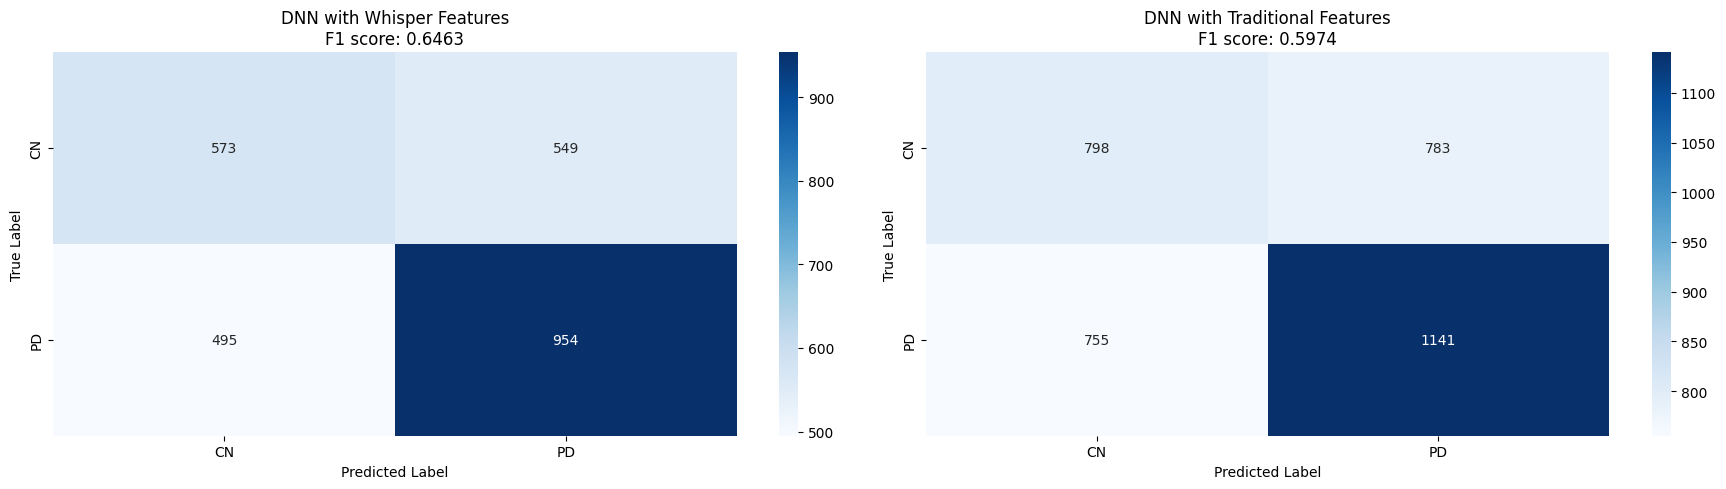

In [11]:
def compare_features(dataset_path):
    """Compare Whisper features with traditional acoustic features, prioritizing CSV loading."""
    # Load dataset and speaker IDs
    all_audio_paths, all_labels, all_speaker_ids = load_parkceleb_dataset_with_speakers(dataset_path)

    # Get unique speaker IDs
    unique_speakers = list(set(all_speaker_ids))

    # Stratify speakers by group if possible (PD vs CN speakers)
    speaker_groups = {speaker: all_labels[all_speaker_ids.index(speaker)] for speaker in unique_speakers}
    pd_speakers = [s for s, label in speaker_groups.items() if label == 1]
    cn_speakers = [s for s, label in speaker_groups.items() if label == 0]

    # Split speakers into train and test sets
    train_speakers_pd, test_speakers_pd = train_test_split(pd_speakers, test_size=0.2, random_state=42)
    train_speakers_cn, test_speakers_cn = train_test_split(cn_speakers, test_size=0.2, random_state=42)

    train_speakers = train_speakers_pd + train_speakers_cn
    test_speakers = test_speakers_pd + test_speakers_cn

    # Filter audio paths and labels based on speaker split
    train_paths = [path for path, speaker_id in zip(all_audio_paths, all_speaker_ids) if speaker_id in train_speakers]
    test_paths = [path for path, speaker_id in zip(all_audio_paths, all_speaker_ids) if speaker_id in test_speakers]
    train_labels = [label for path, speaker_id, label in zip(all_audio_paths, all_speaker_ids, all_labels) if speaker_id in train_speakers]
    test_labels = [label for path, speaker_id, label in zip(all_audio_paths, all_speaker_ids, all_labels) if speaker_id in test_speakers]

    # Ensure train and test labels are lists of integers
    train_labels = [int(l) for l in train_labels]
    test_labels = [int(l) for l in test_labels]

    print(f"Number of training audio files: {len(train_paths)}")
    print(f"Number of testing audio files: {len(test_paths)}")

    whisper_train_csv = "whisper_train_features.csv"
    whisper_test_csv = "whisper_test_features.csv"
    traditional_train_csv = "traditional_train_features.csv"
    traditional_test_csv = "traditional_test_features.csv"

    # Process Whisper Features
    whisper_features_train, train_labels_whisper = load_features_from_csv(whisper_train_csv)
    whisper_features_test, test_labels_whisper = load_features_from_csv(whisper_test_csv)

    if whisper_features_train is None or whisper_features_test is None:
        print("CSV files for Whisper features not found")
        print("Extracting Traditional Features")
        whisper_features_train, train_paths_whisper = extract_whisper_features(train_paths)
        whisper_features_test, test_paths_whisper = extract_whisper_features(test_paths)

        # Filter labels based on successful extraction
        train_labels_whisper = [label for path, label in zip(train_paths, train_labels) if path in train_paths_whisper]
        test_labels_whisper = [label for path, label in zip(test_paths, test_labels) if path in test_paths_whisper]

        # Save features after extraction
        if whisper_features_train.size > 0:
             save_features(whisper_features_train, train_labels_whisper, whisper_train_csv)
        if whisper_features_test.size > 0:
             save_features(whisper_features_test, test_labels_whisper, whisper_test_csv)
    else:
         print("Successfully loaded Whisper features from CSV.")

    # Standardize Whisper features (regardless of origin)
    scaler_whisper = StandardScaler()
    if whisper_features_train is not None and whisper_features_train.size > 0:
        whisper_features_train = scaler_whisper.fit_transform(whisper_features_train)
    if whisper_features_test is not None and whisper_features_test.size > 0:
        # Ensure the test scaler is fitted on the *training* data
        # If loading from CSV, this fit was done previously.
        # If extracted now, fit on train data first.
        if whisper_features_train is not None and whisper_features_train.size > 0:
             whisper_features_test = scaler_whisper.transform(whisper_features_test)
        else:
             print("Warning: Could not apply scaler to Whisper test features (empty train set).")


    # Traditional Features
    traditional_features_train, train_labels_traditional = load_features_from_csv(traditional_train_csv)
    traditional_features_test, test_labels_traditional = load_features_from_csv(traditional_test_csv)

    if traditional_features_train is None or traditional_features_test is None:
        print("CSV files for Traditional features not found")
        print("Extracting Traditional Features")
        traditional_features_train, train_paths_traditional = extract_traditional_features(train_paths)
        traditional_features_test, test_paths_traditional = extract_traditional_features(test_paths)

        # Filter labels based on successful extraction
        train_labels_traditional = [label for path, label in zip(train_paths, train_labels) if path in train_paths_traditional]
        test_labels_traditional = [label for path, label in zip(test_paths, test_labels) if path in test_paths_traditional]

        # Save features after extraction
        if traditional_features_train.size > 0:
            save_features(traditional_features_train, train_labels_traditional, traditional_train_csv)
        if traditional_features_test.size > 0:
            save_features(traditional_features_test, test_labels_traditional, traditional_test_csv)
    else:
        print("Successfully loaded Traditional features from CSV.")

    # Standardize Traditional features (regardless of origin)
    scaler_traditional = StandardScaler()
    if traditional_features_train is not None and traditional_features_train.size > 0:
         traditional_features_train = scaler_traditional.fit_transform(traditional_features_train)
    if traditional_features_test is not None and traditional_features_test.size > 0:
         # Ensure the test scaler is fitted on the *training* data
         if traditional_features_train is not None and traditional_features_train.size > 0:
             traditional_features_test = scaler_traditional.transform(traditional_features_test)
         else:
             print("Warning: Could not apply scaler to Traditional test features (empty train set).")

    # Evaluate using DNN
    print("\nEvaluating with DNN using Whisper features...")
    dnn_whisper_results = train_evaluate_dnn(
        whisper_features_train, train_labels_whisper,
        whisper_features_test, test_labels_whisper
    )

    print("\nEvaluating with DNN using Traditional features...")
    dnn_traditional_results = train_evaluate_dnn(
        traditional_features_train, train_labels_traditional,
        traditional_features_test, test_labels_traditional
    )

    results = {
        "DNN with Whisper Features": dnn_whisper_results,
        "DNN with Traditional Features": dnn_traditional_results
    }

    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  ROC AUC: {metrics['roc_auc']:.4f}")
        print(f"  Sensitivity: {metrics['sensitivity']:.4f}")
        print(f"  Specificity: {metrics['specificity']:.4f}")
        print(f"  F1-Score: {metrics['f1_score']:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    for i, (model_name, metrics) in enumerate(results.items()):
        sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['CN', 'PD'], yticklabels=['CN', 'PD']) # Add labels
        axes[i].set_title(f"{model_name}\nF1 score: {metrics['f1_score']:.4f}")
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.savefig("feature_comparison_results_speaker_split.png")
    plt.show()

    return results


dataset_path = "parkceleb_filtered"
results = compare_features(dataset_path)

# Individuals in training and testing sets

In [12]:
all_audio_paths, all_labels, all_speaker_ids = load_parkceleb_dataset_with_speakers("ParkCeleb_filtered")

# Get unique speaker IDs
unique_speakers = list(set(all_speaker_ids))

# Stratify speakers by group if possible (PD vs CN speakers)
speaker_groups = {speaker: all_labels[all_speaker_ids.index(speaker)] for speaker in unique_speakers}
pd_speakers = [s for s, label in speaker_groups.items() if label == 1]
cn_speakers = [s for s, label in speaker_groups.items() if label == 0]

# Split speakers into train and test sets
train_speakers_pd, test_speakers_pd = train_test_split(pd_speakers, test_size=0.2, random_state=42)
train_speakers_cn, test_speakers_cn = train_test_split(cn_speakers, test_size=0.2, random_state=42)

train_speakers = train_speakers_pd + train_speakers_cn
test_speakers = test_speakers_pd + test_speakers_cn

# Print speaker IDs in each set
print("\nTraining Set Speaker IDs:")
print(f"  PD Speakers: {sorted(train_speakers_pd, key=lambda x: int(''.join(filter(str.isdigit, x))))}")  # Numeric sort
print(f"  CN Speakers: {sorted(train_speakers_cn, key=lambda x: int(''.join(filter(str.isdigit, x))))}\n")

print("Test Set Speaker IDs:")
print(f"  PD Speakers: {sorted(test_speakers_pd, key=lambda x: int(''.join(filter(str.isdigit, x))))}")
print(f"  CN Speakers: {sorted(test_speakers_cn, key=lambda x: int(''.join(filter(str.isdigit, x))))}\n")


Training Set Speaker IDs:
  PD Speakers: ['pd_01', 'pd_03', 'pd_05', 'pd_07', 'pd_08', 'pd_11', 'pd_12', 'pd_13', 'pd_14', 'pd_16', 'pd_19', 'pd_20', 'pd_23', 'pd_25', 'pd_27', 'pd_28', 'pd_30', 'pd_31', 'pd_32', 'pd_33', 'pd_34', 'pd_36', 'pd_37', 'pd_38']
  CN Speakers: ['cn_01', 'cn_03', 'cn_05', 'cn_06', 'cn_07', 'cn_08', 'cn_12', 'cn_13', 'cn_14', 'cn_16', 'cn_18', 'cn_20', 'cn_24', 'cn_25', 'cn_27', 'cn_28', 'cn_30', 'cn_31', 'cn_32', 'cn_33', 'cn_34', 'cn_35', 'cn_36', 'cn_37']

Test Set Speaker IDs:
  PD Speakers: ['pd_06', 'pd_10', 'pd_17', 'pd_18', 'pd_24', 'pd_29', 'pd_35']
  CN Speakers: ['cn_10', 'cn_11', 'cn_17', 'cn_19', 'cn_23', 'cn_29', 'cn_38']

